# Camera and Images with Aurora SDK

This notebook demonstrates how to work with camera data from Aurora devices, including:

1. Camera preview images (stereo)
2. Tracking frames with keypoints
3. Image format conversion
4. Camera calibration data
5. Real-time image display
6. Image processing and analysis

## Prerequisites

- Completed the [Getting Started](01_getting_started.ipynb) notebook
- Aurora device connected
- OpenCV and matplotlib for image display

## Setup and Imports

In [1]:
# Core imports
from slamtec_aurora_sdk import AuroraSDK
from slamtec_aurora_sdk.exceptions import DataNotReadyError
import numpy as np
import time

# Image processing and display
try:
    import cv2
    OPENCV_AVAILABLE = True
    print("✅ OpenCV available for image processing")
except ImportError:
    OPENCV_AVAILABLE = False
    print("⚠️ OpenCV not available. Install with: pip install opencv-python")

try:
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    MATPLOTLIB_AVAILABLE = True
    print("✅ Matplotlib available for plotting")
    
    # Configure matplotlib for notebook
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (12, 8)
except ImportError:
    MATPLOTLIB_AVAILABLE = False
    print("⚠️ Matplotlib not available. Install with: pip install matplotlib")

try:
    from PIL import Image
    PIL_AVAILABLE = True
    print("✅ PIL available for image conversion")
except ImportError:
    PIL_AVAILABLE = False
    print("⚠️ PIL not available. Install with: pip install Pillow")

✅ OpenCV available for image processing
✅ Matplotlib available for plotting
✅ PIL available for image conversion


## Step 1: Connect to Device

Let's establish a connection to the Aurora device.

In [3]:
# Connect to device using context manager
device_ip = "192.168.11.1"  # Replace with your device IP

# Create SDK instance
sdk = AuroraSDK()

try:
    # Connect to device
    print(f"Connecting to Aurora device at {device_ip}...")
    sdk.connect(connection_string=device_ip)
    print("✅ Connected successfully!")
    
    # Get device info
    device_info = sdk.get_device_info()
    print(f"📱 Device: {device_info.device_name} ({device_info.device_model_string})")
    
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("Please check your device IP and network connection.")

Connecting to Aurora device at 192.168.1.212...
✅ Connected successfully!
📱 Device: Aurora (A1M1)


## Step 2: Camera Preview Images

Aurora devices provide stereo camera data. Let's capture and display camera preview images.

📸 Capturing camera preview images...
✅ Camera images captured!
Left image: 640x480, format: 0
Right image: 640x480, format: 0
Timestamp: 3241807205286 ns
Converted to OpenCV format: (480, 640, 3)


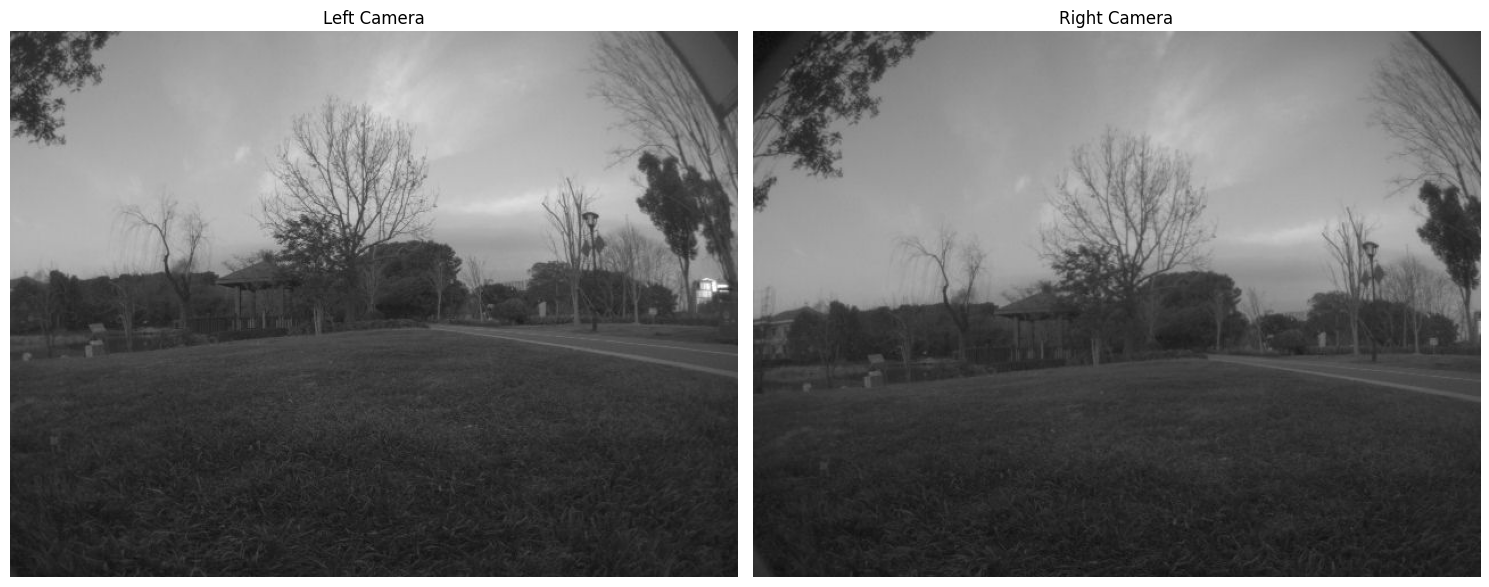

In [6]:
if sdk.is_connected():
    try:
        print("📸 Capturing camera preview images...")
        
        # Get camera preview (stereo images)
        left_frame, right_frame = sdk.data_provider.get_camera_preview()
        
        if left_frame and right_frame:
            print("✅ Camera images captured!")
            print(f"Left image: {left_frame.width}x{left_frame.height}, format: {left_frame.pixel_format}")
            print(f"Right image: {right_frame.width}x{right_frame.height}, format: {right_frame.pixel_format}")
            print(f"Timestamp: {left_frame.timestamp_ns} ns")
            
            # Convert to display format
            if OPENCV_AVAILABLE:
                left_img = left_frame.to_opencv_image()
                right_img = right_frame.to_opencv_image()
                
                if left_img is not None and right_img is not None:
                    print(f"Converted to OpenCV format: {left_img.shape}")
                    
                    # Display using matplotlib
                    if MATPLOTLIB_AVAILABLE:
                        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
                        
                        # Convert BGR to RGB for matplotlib
                        if len(left_img.shape) == 3:
                            left_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
                            right_rgb = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
                        else:
                            left_rgb = left_img
                            right_rgb = right_img
                        
                        ax1.imshow(left_rgb, cmap='gray' if len(left_img.shape) == 2 else None)
                        ax1.set_title('Left Camera')
                        ax1.axis('off')
                        
                        ax2.imshow(right_rgb, cmap='gray' if len(right_img.shape) == 2 else None)
                        ax2.set_title('Right Camera')
                        ax2.axis('off')
                        
                        plt.tight_layout()
                        plt.show()
                else:
                    print("⚠️ Failed to convert images to OpenCV format")
            else:
                print("⚠️ OpenCV not available for image conversion")
        else:
            print("❌ No camera images available")
            
    except DataNotReadyError:
        print("⏳ Camera data not ready. Device may still be initializing.")
    except Exception as e:
        print(f"❌ Failed to get camera preview: {e}")
else:
    print("❌ Not connected to device")

## Step 3: Tracking Frames with Keypoints

Aurora provides tracking frames that include not just images, but also feature keypoints for SLAM.

🎯 Capturing tracking frame with keypoints...
✅ Tracking frame captured!
Images: 640x480
Keypoints: 447 left, 421 right

📊 Sample left keypoints:
  0: (551.0, 208.0) - available attributes: ['flags', 'x', 'y']...
  1: (463.0, 8.0) - available attributes: ['flags', 'x', 'y']...
  2: (585.0, 303.0) - available attributes: ['flags', 'x', 'y']...
  3: (502.0, 16.0) - available attributes: ['flags', 'x', 'y']...
  4: (622.0, 298.0) - available attributes: ['flags', 'x', 'y']...


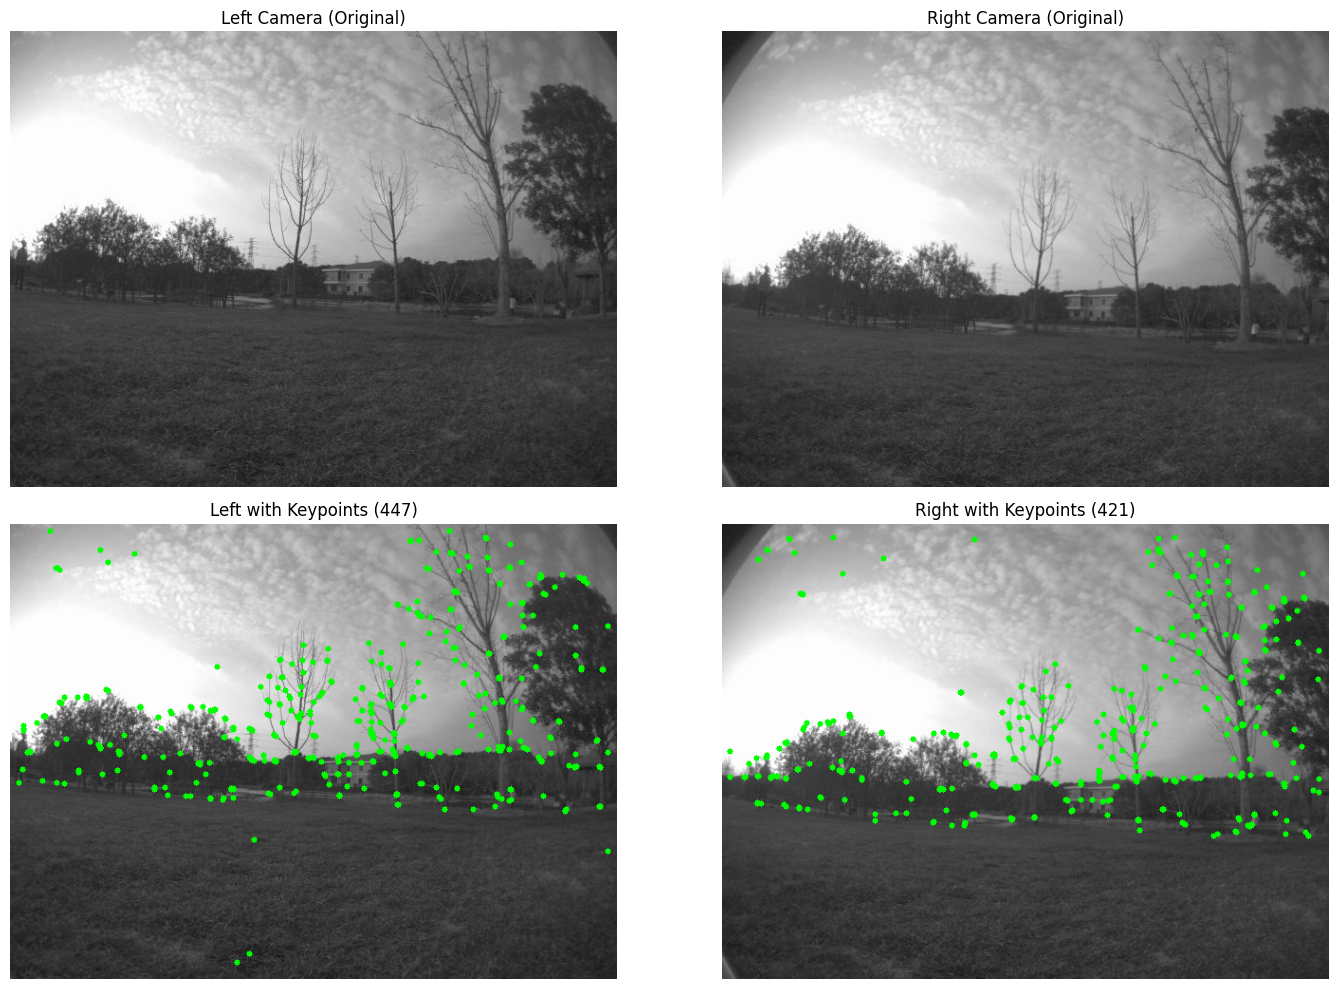

In [11]:
if sdk.is_connected():
    try:
        print("🎯 Capturing tracking frame with keypoints...")
        
        # Get tracking frame (includes images + keypoints)
        tracking_frame = sdk.data_provider.get_tracking_frame()
        
        if tracking_frame and tracking_frame.left_image and tracking_frame.right_image:
            print("✅ Tracking frame captured!")
            
            # Image information
            left_img = tracking_frame.left_image
            right_img = tracking_frame.right_image
            print(f"Images: {left_img.width}x{left_img.height}")
            
            # Keypoint information
            left_keypoints = tracking_frame.left_keypoints
            right_keypoints = tracking_frame.right_keypoints
            print(f"Keypoints: {len(left_keypoints)} left, {len(right_keypoints)} right")
            
            # Display sample keypoints (only x and y coordinates)
            if left_keypoints:
                print("\n📊 Sample left keypoints:")
                for i, kp in enumerate(left_keypoints[:5]):  # Show first 5
                    # Check what attributes are available
                    available_attrs = [attr for attr in dir(kp) if not attr.startswith('_')]
                    print(f"  {i}: ({kp.x:.1f}, {kp.y:.1f}) - available attributes: {available_attrs[:3]}...")
            
            # Visualize keypoints on images
            if OPENCV_AVAILABLE and MATPLOTLIB_AVAILABLE:
                left_cv = left_img.to_opencv_image()
                right_cv = right_img.to_opencv_image()
                
                if left_cv is not None and right_cv is not None:
                    # Draw keypoints using the tracking frame's built-in method
                    left_with_kp = left_cv.copy()
                    right_with_kp = right_cv.copy()
                    
                    # Use tracking frame's keypoint drawing method
                    tracking_frame.draw_keypoints_on_image(left_with_kp, 'left')
                    tracking_frame.draw_keypoints_on_image(right_with_kp, 'right')
                    
                    # Display
                    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                    
                    # Convert BGR to RGB for matplotlib
                    if len(left_cv.shape) == 3:
                        left_rgb = cv2.cvtColor(left_cv, cv2.COLOR_BGR2RGB)
                        right_rgb = cv2.cvtColor(right_cv, cv2.COLOR_BGR2RGB)
                        left_kp_rgb = cv2.cvtColor(left_with_kp, cv2.COLOR_BGR2RGB)
                        right_kp_rgb = cv2.cvtColor(right_with_kp, cv2.COLOR_BGR2RGB)
                    else:
                        left_rgb = left_cv
                        right_rgb = right_cv
                        left_kp_rgb = left_with_kp
                        right_kp_rgb = right_with_kp
                    
                    # Original images
                    axes[0,0].imshow(left_rgb, cmap='gray' if len(left_cv.shape) == 2 else None)
                    axes[0,0].set_title('Left Camera (Original)')
                    axes[0,0].axis('off')
                    
                    axes[0,1].imshow(right_rgb, cmap='gray' if len(right_cv.shape) == 2 else None)
                    axes[0,1].set_title('Right Camera (Original)')
                    axes[0,1].axis('off')
                    
                    # Images with keypoints
                    axes[1,0].imshow(left_kp_rgb, cmap='gray' if len(left_with_kp.shape) == 2 else None)
                    axes[1,0].set_title(f'Left with Keypoints ({len(left_keypoints)})')
                    axes[1,0].axis('off')
                    
                    axes[1,1].imshow(right_kp_rgb, cmap='gray' if len(right_with_kp.shape) == 2 else None)
                    axes[1,1].set_title(f'Right with Keypoints ({len(right_keypoints)})')
                    axes[1,1].axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
        else:
            print("❌ No tracking frame available")
            
    except DataNotReadyError:
        print("⏳ Tracking data not ready")
    except Exception as e:
        print(f"❌ Failed to get tracking frame: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Not connected to device")

## Step 4: Camera Calibration Data

Aurora devices provide camera calibration information essential for accurate measurements and 3D reconstruction.

📏 Getting camera calibration data...
✅ Camera calibration data available!

Camera type: 1 (STEREO)

📷 Left Camera Intrinsics:
  Image size: 640x480
  Lens type: KANNALABRANDT
  Color mode: MONO
  FPS: 15
  Focal length: fx=279.38, fy=279.33
  Principal point: cx=312.57, cy=276.32
  Distortion: k1=-0.027628, k2=-0.010797, k3=0.004802, k4=-0.001274

📷 Right Camera Intrinsics:
  Image size: 640x480
  Lens type: KANNALABRANDT
  Color mode: MONO
  FPS: 15
  Focal length: fx=279.30, fy=279.27
  Principal point: cx=307.96, cy=271.97
  Distortion: k1=-0.036598, k2=0.006522, k3=-0.007158, k4=0.001511

🔗 Stereo Calibration:
  Raw transformation matrix values:
    t_matrix[0] = 0.999819
    t_matrix[1] = 0.019028
    t_matrix[2] = -0.000741
    t_matrix[3] = -0.060281
    t_matrix[4] = -0.019028
    t_matrix[5] = 0.999819
    t_matrix[6] = 0.000201
    t_matrix[7] = 0.000781
    t_matrix[8] = 0.000744
    t_matrix[9] = -0.000187
    t_matrix[10] = 1.000000
    t_matrix[11] = -0.000052
    t_matri

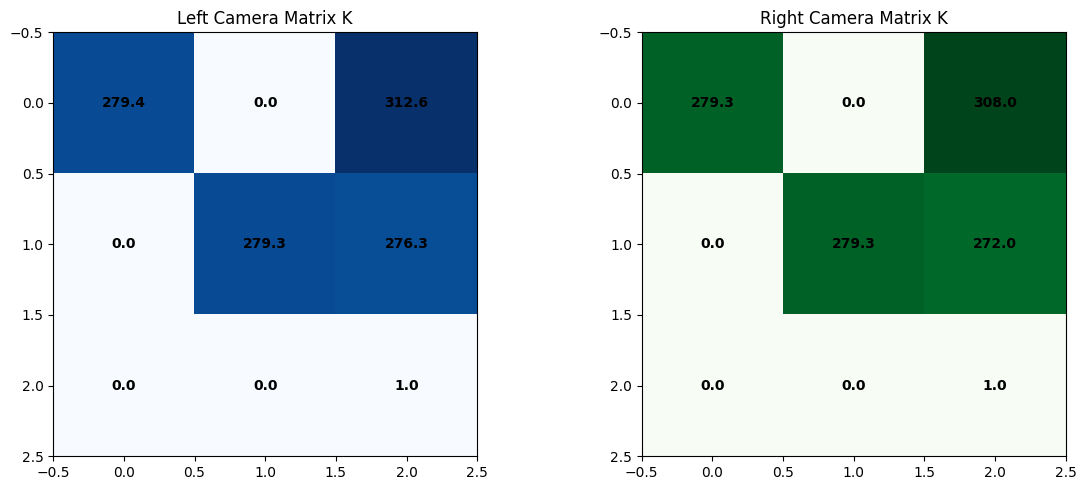

In [5]:
if sdk.is_connected():
    try:
        print("📏 Getting camera calibration data...")
        
        # Get camera calibration
        camera_calib = sdk.data_provider.get_camera_calibration()
        
        if camera_calib:
            print("✅ Camera calibration data available!")
            
            # Camera calibration info structure contains:
            # - camera_type: 0=MONO, 1=STEREO
            # - camera_calibration: array of SingleCameraCalibration (4 elements)
            # - ext_camera_transform: array of ExtCameraTransform (4 elements)
            
            print(f"\nCamera type: {camera_calib.camera_type} ({'MONO' if camera_calib.camera_type == 0 else 'STEREO'})")
            
            # For stereo cameras, camera_calibration[0] is left, camera_calibration[1] is right
            left_calib = camera_calib.camera_calibration[0]
            right_calib = camera_calib.camera_calibration[1]
            
            # Helper function to get lens type string
            def get_lens_type_str(len_type):
                if len_type == 0:
                    return "PINHOLE"
                elif len_type == 1:
                    return "RECTIFIED"
                elif len_type == 2:
                    return "KANNALABRANDT"
                else:
                    return f"UNKNOWN({len_type})"
            
            # Helper function to get color mode string
            def get_color_mode_str(color_mode):
                if color_mode == 0:
                    return "RGB"
                elif color_mode == 1:
                    return "MONO"
                else:
                    return f"UNKNOWN({color_mode})"
            
            # Left camera intrinsics
            print("\n📷 Left Camera Intrinsics:")
            print(f"  Image size: {left_calib.width}x{left_calib.height}")
            print(f"  Lens type: {get_lens_type_str(left_calib.len_type)}")
            print(f"  Color mode: {get_color_mode_str(left_calib.color_mode)}")
            print(f"  FPS: {left_calib.fps}")
            
            # Intrinsics array: [fx, fy, cx, cy]
            fx_left, fy_left, cx_left, cy_left = left_calib.intrinsics[:4]
            print(f"  Focal length: fx={fx_left:.2f}, fy={fy_left:.2f}")
            print(f"  Principal point: cx={cx_left:.2f}, cy={cy_left:.2f}")
            
            # Distortion coefficients: [k1, k2, k3, k4, unused]
            k1, k2, k3, k4, _ = left_calib.distortion[:5]
            print(f"  Distortion: k1={k1:.6f}, k2={k2:.6f}, k3={k3:.6f}, k4={k4:.6f}")
            
            # Right camera intrinsics
            print("\n📷 Right Camera Intrinsics:")
            print(f"  Image size: {right_calib.width}x{right_calib.height}")
            print(f"  Lens type: {get_lens_type_str(right_calib.len_type)}")
            print(f"  Color mode: {get_color_mode_str(right_calib.color_mode)}")
            print(f"  FPS: {right_calib.fps}")
            
            # Intrinsics array: [fx, fy, cx, cy]
            fx_right, fy_right, cx_right, cy_right = right_calib.intrinsics[:4]
            print(f"  Focal length: fx={fx_right:.2f}, fy={fy_right:.2f}")
            print(f"  Principal point: cx={cx_right:.2f}, cy={cy_right:.2f}")
            
            # Distortion coefficients: [k1, k2, k3, k4, unused]
            k1_r, k2_r, k3_r, k4_r, _ = right_calib.distortion[:5]
            print(f"  Distortion: k1={k1_r:.6f}, k2={k2_r:.6f}, k3={k3_r:.6f}, k4={k4_r:.6f}")
            
            # Stereo calibration info (baseline from external transform)
            print("\n🔗 Stereo Calibration:")
            ext_transform = camera_calib.ext_camera_transform[0]  # Transform from camera 2 to camera 1
            
            # The transformation matrix is stored as a 4x4 matrix in column-major order
            # Convert to Python list for easier access
            t_matrix = list(ext_transform.t_c2_c1[:16])
            
            # Print raw matrix values for debugging
            print("  Raw transformation matrix values:")
            for i, val in enumerate(t_matrix):
                print(f"    t_matrix[{i}] = {val:.6f}")
            
            # Extract translation components using column-major indexing
            # In column-major 4x4 matrix: translation is at indices 3, 7, 11 (not 12, 13, 14)
            tx = t_matrix[3]   # Translation in X (first column, 4th element)
            ty = t_matrix[7]   # Translation in Y (second column, 4th element) 
            tz = t_matrix[11]  # Translation in Z (third column, 4th element)
            
            # Display 4x4 transformation matrix in readable format (column-major to row-major)
            print("  Transformation Matrix (camera 2 to camera 1) - displayed in row-major:")
            for row in range(4):
                row_values = [f"{t_matrix[row + col*4]:12.6f}" for col in range(4)]  # Column-major access
                print(f"    [{', '.join(row_values)}]")
            
            baseline = abs(tx)  # Baseline is typically the X translation magnitude
            print(f"  Translation vector: [{tx:.6f}, {ty:.6f}, {tz:.6f}]")
            print(f"  Baseline (estimated): {baseline:.4f} meters ({baseline*1000:.1f} mm)")
            
            # Additional stereo parameters
            if baseline > 0.001:  # Check for reasonable baseline (> 1mm)
                # Calculate depth resolution at 1 meter
                avg_focal_length = (fx_left + fx_right) / 2
                max_disparity = left_calib.width  # Maximum possible disparity
                min_depth = (baseline * avg_focal_length) / max_disparity
                max_depth = baseline * avg_focal_length / 1.0  # Assuming 1 pixel minimum disparity
                
                print(f"  Average focal length: {avg_focal_length:.2f} pixels")
                print(f"  Estimated depth range: {min_depth:.2f}m to {max_depth:.1f}m")
                print(f"  Depth resolution at 1m: {baseline / avg_focal_length:.4f}m per pixel")
            else:
                print("  ⚠️ No valid baseline detected. Transform may be identity matrix.")
                print("     This could indicate:")
                print("     - Device calibration is not available")
                print("     - Single camera system")
                print("     - Calibration data not yet loaded")
            
            # Create camera matrix visualization
            if MATPLOTLIB_AVAILABLE:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                
                # Left camera matrix
                K_left = np.array([
                    [fx_left, 0, cx_left],
                    [0, fy_left, cy_left],
                    [0, 0, 1]
                ])
                
                # Right camera matrix
                K_right = np.array([
                    [fx_right, 0, cx_right],
                    [0, fy_right, cy_right],
                    [0, 0, 1]
                ])
                
                # Display matrices
                im1 = ax1.imshow(K_left, cmap='Blues')
                ax1.set_title('Left Camera Matrix K')
                for i in range(3):
                    for j in range(3):
                        ax1.text(j, i, f'{K_left[i,j]:.1f}', ha='center', va='center', fontweight='bold')
                
                im2 = ax2.imshow(K_right, cmap='Greens')
                ax2.set_title('Right Camera Matrix K')
                for i in range(3):
                    for j in range(3):
                        ax2.text(j, i, f'{K_right[i,j]:.1f}', ha='center', va='center', fontweight='bold')
                
                plt.tight_layout()
                plt.show()
        else:
            print("❌ No camera calibration data available")
            
    except Exception as e:
        print(f"❌ Failed to get camera calibration: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Not connected to device")

## Step 5: Image Format Conversion

Aurora SDK supports multiple image formats. Let's explore different conversion options.

🔄 Exploring image format conversions...

📋 Original frame info:
  Size: 640 x 480
  Format: 0
  Data size: 307200 bytes
  Timestamp: 2472007238689 ns

🖼️ OpenCV conversion:
  Shape: (480, 640, 3)
  Dtype: uint8
  Min/Max values: 18/255


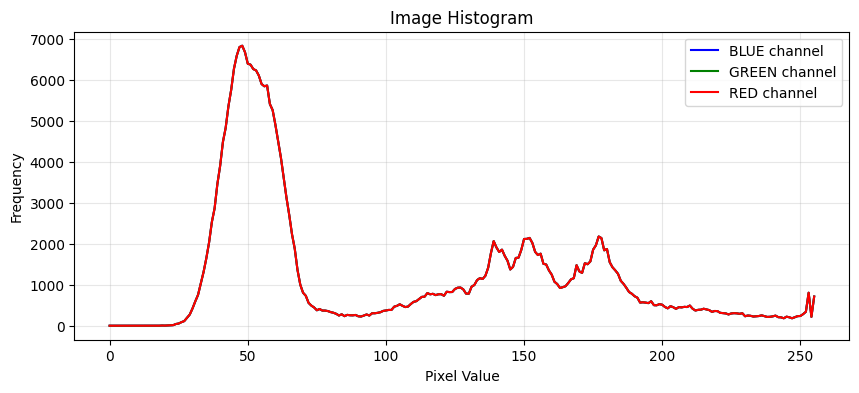

⚠️ PIL conversion not available in this SDK version

📊 Raw data access:
  Data type: <class 'bytes'>
  Length: 307200 bytes
  As numpy array: shape (307200,), dtype uint8
  Reshaped (grayscale): (480, 640)


In [14]:
if sdk.is_connected():
    try:
        print("🔄 Exploring image format conversions...")
        
        # Get a camera frame
        left_frame, right_frame = sdk.data_provider.get_camera_preview()
        
        if left_frame:
            print(f"\n📋 Original frame info:")
            print(f"  Size: {left_frame.width} x {left_frame.height}")
            print(f"  Format: {left_frame.pixel_format}")
            print(f"  Data size: {len(left_frame.data)} bytes")
            print(f"  Timestamp: {left_frame.timestamp_ns} ns")
            
            # Conversion to OpenCV
            if OPENCV_AVAILABLE:
                cv_image = left_frame.to_opencv_image()
                if cv_image is not None:
                    print(f"\n🖼️ OpenCV conversion:")
                    print(f"  Shape: {cv_image.shape}")
                    print(f"  Dtype: {cv_image.dtype}")
                    print(f"  Min/Max values: {cv_image.min()}/{cv_image.max()}")
                    
                    # Show histogram
                    if MATPLOTLIB_AVAILABLE:
                        plt.figure(figsize=(10, 4))
                        
                        if len(cv_image.shape) == 3:  # Color image
                            colors = ['blue', 'green', 'red']
                            for i, color in enumerate(colors):
                                hist = cv2.calcHist([cv_image], [i], None, [256], [0, 256])
                                plt.plot(hist, color=color, label=f'{color.upper()} channel')
                        else:  # Grayscale
                            hist = cv2.calcHist([cv_image], [0], None, [256], [0, 256])
                            plt.plot(hist, color='gray', label='Intensity')
                        
                        plt.title('Image Histogram')
                        plt.xlabel('Pixel Value')
                        plt.ylabel('Frequency')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        plt.show()
            
            # Conversion to PIL
            if PIL_AVAILABLE:
                try:
                    pil_image = left_frame.to_pil_image()
                    if pil_image:
                        print(f"\n🖼️ PIL conversion:")
                        print(f"  Mode: {pil_image.mode}")
                        print(f"  Size: {pil_image.size}")
                        print(f"  Format: {pil_image.format}")
                except AttributeError:
                    print("⚠️ PIL conversion not available in this SDK version")
            
            # Raw data access
            print(f"\n📊 Raw data access:")
            raw_data = left_frame.data
            print(f"  Data type: {type(raw_data)}")
            print(f"  Length: {len(raw_data)} bytes")
            
            # Convert raw data to numpy array (basic approach)
            if OPENCV_AVAILABLE:
                try:
                    # Attempt to reshape raw data
                    raw_array = np.frombuffer(raw_data, dtype=np.uint8)
                    print(f"  As numpy array: shape {raw_array.shape}, dtype {raw_array.dtype}")
                    
                    # Try to reshape to image dimensions
                    expected_size = left_frame.width * left_frame.height
                    if len(raw_array) == expected_size:  # Grayscale
                        reshaped = raw_array.reshape(left_frame.height, left_frame.width)
                        print(f"  Reshaped (grayscale): {reshaped.shape}")
                    elif len(raw_array) == expected_size * 3:  # RGB
                        reshaped = raw_array.reshape(left_frame.height, left_frame.width, 3)
                        print(f"  Reshaped (RGB): {reshaped.shape}")
                    else:
                        print(f"  Unexpected data size: {len(raw_array)} bytes")
                        
                except Exception as e:
                    print(f"  Raw conversion error: {e}")
        else:
            print("❌ No frame available for format testing")
            
    except Exception as e:
        print(f"❌ Format conversion error: {e}")
else:
    print("❌ Not connected to device")

## Step 6: Real-time Image Capture

Let's capture a sequence of images to see how the camera data changes over time.

🎬 Capturing image sequence (10 frames over 5 seconds)...
Move the Aurora device to see changes in the images!
Capturing frame 1/10... ✅
Capturing frame 2/10... ✅
Capturing frame 3/10... ✅
Capturing frame 4/10... ✅
Capturing frame 5/10... ✅
Capturing frame 6/10... ✅
Capturing frame 7/10... ✅
Capturing frame 8/10... ✅
Capturing frame 9/10... ✅
Capturing frame 10/10... ✅

📸 Displaying 10 captured frames...


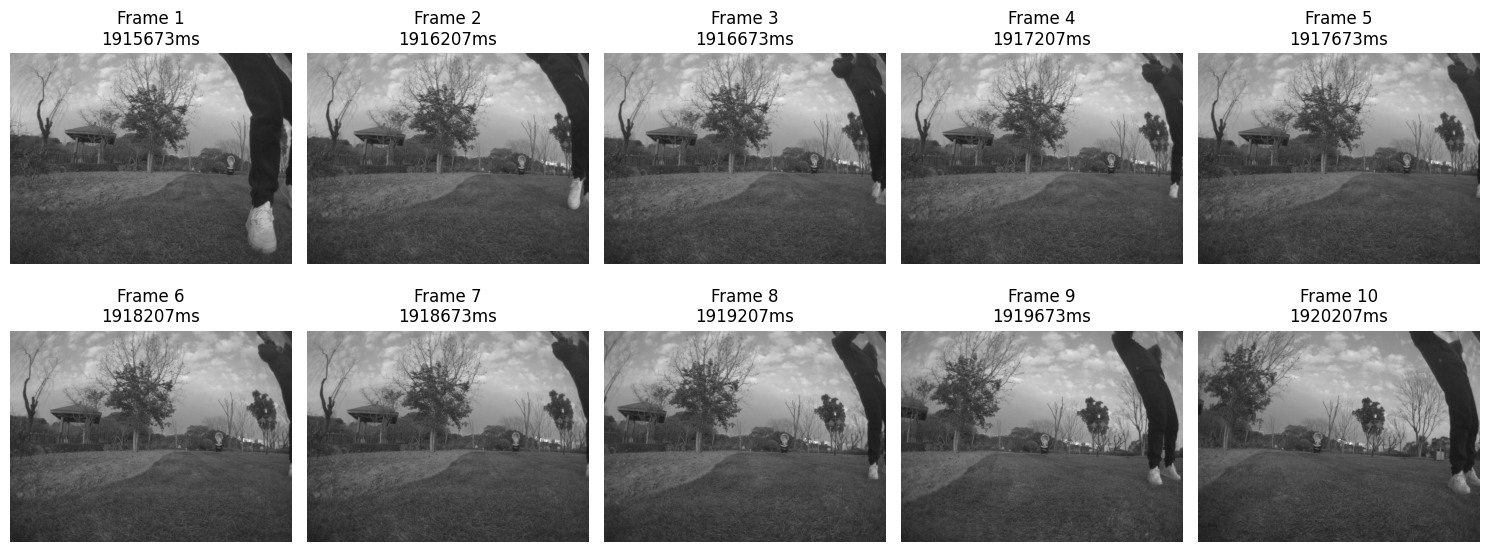

📊 Capture statistics:
  Total time: 4.53 seconds
  Average FPS: 1.99 Hz


In [16]:
if sdk.is_connected() and OPENCV_AVAILABLE and MATPLOTLIB_AVAILABLE:
    print("🎬 Capturing image sequence (10 frames over 5 seconds)...")
    print("Move the Aurora device to see changes in the images!")
    
    frames = []
    timestamps = []
    
    try:
        for i in range(10):
            print(f"Capturing frame {i+1}/10...", end=" ")
            
            # Get frame
            left_frame, right_frame = sdk.data_provider.get_camera_preview()
            
            if left_frame:
                # Convert to OpenCV
                cv_img = left_frame.to_opencv_image()
                if cv_img is not None:
                    frames.append(cv_img)
                    timestamps.append(left_frame.timestamp_ns)
                    print("✅")
                else:
                    print("❌ Conversion failed")
            else:
                print("❌ No frame")
            
            time.sleep(0.5)  # Wait 0.5 seconds between captures
        
        # Display captured frames
        if frames:
            print(f"\n📸 Displaying {len(frames)} captured frames...")
            
            # Create a grid display
            cols = 5
            rows = (len(frames) + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
            if rows == 1:
                axes = axes.reshape(1, -1)
            
            for i, (frame, ts) in enumerate(zip(frames, timestamps)):
                row = i // cols
                col = i % cols
                
                # Convert BGR to RGB for matplotlib
                if len(frame.shape) == 3:
                    display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                else:
                    display_frame = frame
                
                axes[row, col].imshow(display_frame, cmap='gray' if len(frame.shape) == 2 else None)
                axes[row, col].set_title(f'Frame {i+1}\n{ts//1000000}ms')
                axes[row, col].axis('off')
            
            # Hide empty subplots
            for i in range(len(frames), rows * cols):
                row = i // cols
                col = i % cols
                axes[row, col].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Calculate frame rate
            if len(timestamps) > 1:
                time_diff = (timestamps[-1] - timestamps[0]) / 1e9  # Convert to seconds
                fps = (len(timestamps) - 1) / time_diff
                print(f"📊 Capture statistics:")
                print(f"  Total time: {time_diff:.2f} seconds")
                print(f"  Average FPS: {fps:.2f} Hz")
        else:
            print("❌ No frames captured")
            
    except KeyboardInterrupt:
        print("\n⏹️ Capture interrupted by user")
    except Exception as e:
        print(f"\n❌ Capture error: {e}")
        
else:
    if not sdk.is_connected():
        print("❌ Not connected to device")
    else:
        print("⚠️ OpenCV and/or Matplotlib not available for real-time capture")

## Step 7: Image Analysis and Processing

Let's perform some basic image analysis on the captured data.

🔍 Performing image analysis...
✅ Analyzing image...

📊 Image Statistics:
  Mean brightness: 94.89
  Std deviation: 50.28
  Min/Max values: 19/255
  Edge ratio: 0.0627 (19251 edge pixels)
  Detected corners: 100


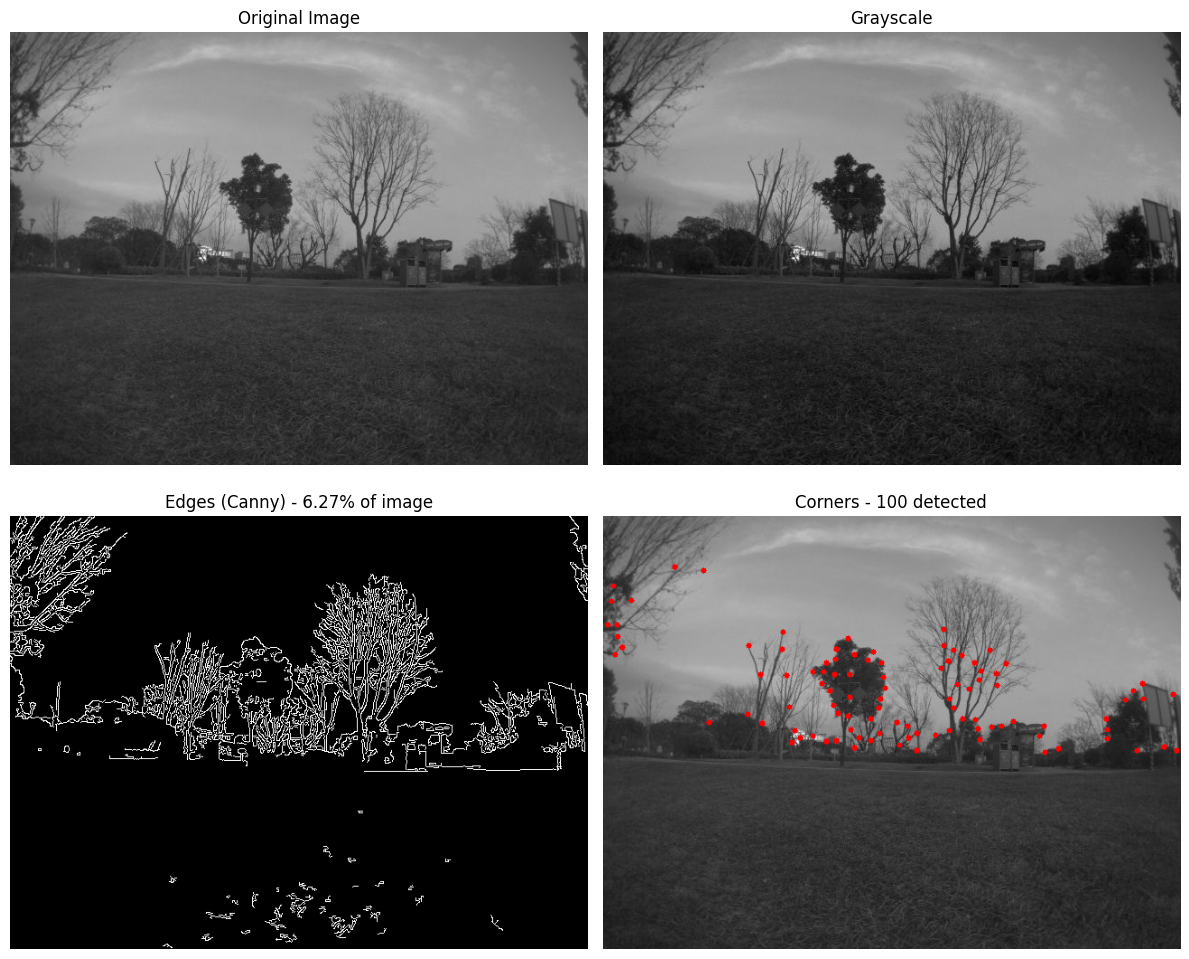

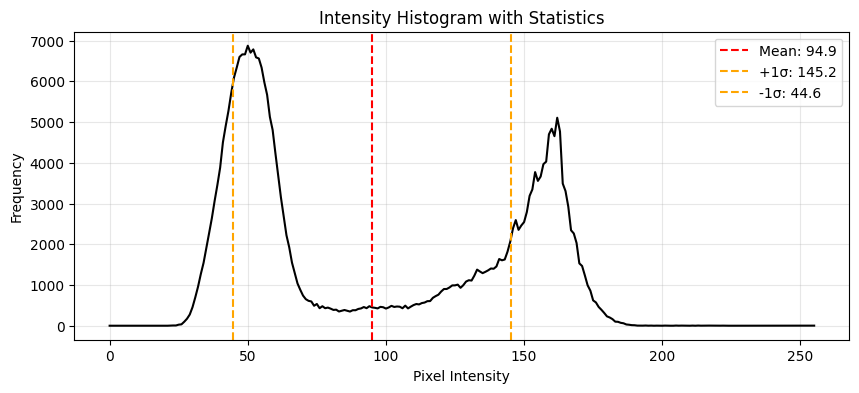

In [10]:
if sdk.is_connected() and OPENCV_AVAILABLE:
    try:
        print("🔍 Performing image analysis...")
        
        # Get current frame
        left_frame, right_frame = sdk.data_provider.get_camera_preview()
        
        if left_frame:
            cv_img = left_frame.to_opencv_image()
            
            if cv_img is not None:
                print("✅ Analyzing image...")
                
                # Convert to grayscale if needed
                if len(cv_img.shape) == 3:
                    gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
                else:
                    gray = cv_img.copy()
                
                # Basic image statistics
                print(f"\n📊 Image Statistics:")
                print(f"  Mean brightness: {np.mean(gray):.2f}")
                print(f"  Std deviation: {np.std(gray):.2f}")
                print(f"  Min/Max values: {np.min(gray)}/{np.max(gray)}")
                
                # Edge detection
                edges = cv2.Canny(gray, 50, 150)
                edge_pixels = np.sum(edges > 0)
                total_pixels = gray.shape[0] * gray.shape[1]
                edge_ratio = edge_pixels / total_pixels
                print(f"  Edge ratio: {edge_ratio:.4f} ({edge_pixels} edge pixels)")
                
                # Corner detection
                corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
                num_corners = len(corners) if corners is not None else 0
                print(f"  Detected corners: {num_corners}")
                
                # Display analysis results
                if MATPLOTLIB_AVAILABLE:
                    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                    
                    # Original image
                    if len(cv_img.shape) == 3:
                        display_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
                    else:
                        display_img = cv_img
                    
                    axes[0,0].imshow(display_img, cmap='gray' if len(cv_img.shape) == 2 else None)
                    axes[0,0].set_title('Original Image')
                    axes[0,0].axis('off')
                    
                    # Grayscale
                    axes[0,1].imshow(gray, cmap='gray')
                    axes[0,1].set_title('Grayscale')
                    axes[0,1].axis('off')
                    
                    # Edges
                    axes[1,0].imshow(edges, cmap='gray')
                    axes[1,0].set_title(f'Edges (Canny) - {edge_ratio:.2%} of image')
                    axes[1,0].axis('off')
                    
                    # Corners
                    corner_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
                    if corners is not None:
                        for corner in corners:
                            x, y = corner.ravel()
                            cv2.circle(corner_img, (int(x), int(y)), 3, (255, 0, 0), -1)
                    
                    axes[1,1].imshow(corner_img)
                    axes[1,1].set_title(f'Corners - {num_corners} detected')
                    axes[1,1].axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # Histogram analysis
                    plt.figure(figsize=(10, 4))
                    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
                    plt.plot(hist, color='black')
                    plt.axvline(np.mean(gray), color='red', linestyle='--', label=f'Mean: {np.mean(gray):.1f}')
                    plt.axvline(np.mean(gray) + np.std(gray), color='orange', linestyle='--', label=f'+1σ: {np.mean(gray) + np.std(gray):.1f}')
                    plt.axvline(np.mean(gray) - np.std(gray), color='orange', linestyle='--', label=f'-1σ: {np.mean(gray) - np.std(gray):.1f}')
                    plt.title('Intensity Histogram with Statistics')
                    plt.xlabel('Pixel Intensity')
                    plt.ylabel('Frequency')
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()
                    
            else:
                print("❌ Failed to convert frame for analysis")
        else:
            print("❌ No frame available for analysis")
            
    except Exception as e:
        print(f"❌ Analysis error: {e}")
else:
    if not sdk.is_connected():
        print("❌ Not connected to device")
    else:
        print("⚠️ OpenCV not available for image analysis")

## Step 8: Cleanup

Always clean up resources when finished.

In [ ]:
# Cleanup
try:
    if sdk.is_connected():
        sdk.disconnect()
        print("✅ Disconnected from device")
    
    sdk.release()
    print("✅ SDK resources released")
    
except Exception as e:
    print(f"⚠️ Cleanup warning: {e}")

print("\n🎉 Camera and Images tutorial completed!")

## Summary

In this notebook, you learned how to:

1. ✅ **Capture camera preview images** from Aurora stereo cameras
2. ✅ **Work with tracking frames** including feature keypoints
3. ✅ **Access camera calibration data** for accurate measurements
4. ✅ **Convert between image formats** (OpenCV, PIL, raw data)
5. ✅ **Capture real-time image sequences** with timestamp analysis
6. ✅ **Perform image analysis** including edge detection and corner detection
7. ✅ **Visualize image data** with histograms and statistical analysis

## Key Concepts

- **Stereo cameras**: Aurora provides left and right camera images for depth perception
- **Tracking frames**: Include both images and feature keypoints for SLAM
- **Camera calibration**: Essential for accurate 3D measurements and reconstruction
- **Image formats**: Multiple conversion options for different processing needs
- **Real-time processing**: Aurora provides continuous image streams

## Next Steps

Continue with more advanced topics:

- **[LiDAR and Point Clouds](03_lidar_and_point_clouds.ipynb)** - Working with 3D scan data
- **[Mapping and Navigation](04_mapping_and_navigation.ipynb)** - SLAM and map building
- **[Enhanced Imaging](05_enhanced_imaging.ipynb)** - Depth cameras and semantic segmentation

## Tips for Camera Processing

1. **Use context managers** for automatic resource cleanup
2. **Handle DataNotReadyError** exceptions gracefully
3. **Check frame timestamps** to avoid processing duplicate frames
4. **Consider image format** requirements for your specific use case
5. **Use camera calibration** for accurate measurements and undistortion